# Capstone Project - The Battle of the Neighborhoods 
## EV Charging Point Analysis in  Milan (Italy)
### Applied Data Science Capstone by IBM/Coursera

### Table of contents
- [Abstract](#abstract)
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology and Analysis](#methodology)
* [Results](#results)
* [Conclusion](#conclusion)

### *Abstract*

*My capstone project is focused on the analysis of the Electric Vehicle (EV) charging station network within the city of Milan. In order to consider the attractiveness of a charging station I will consider the proximity between them and other POI like bars, restaurant and cafe. Since the average EV owner will need to make quick charge stop during the day the best clusters will be the ones with a good concentration of bar and other venues near the charging point where the EVs owners could spend their time during the charging process. I will use a clusterization model (K-Means) to find some cluster with different characteristic and I will identify the best ones following my assumptions*. 


## Introduction: Business Problem

The Mobility and Automotive sector are undertaking a crucial change both in term of business and technologies. This change is led by the **introduction of the Electric Vehicles EV**. Since these vehicles need a public and private charging network the institutions and governments need to enlarge and create efficient **charging points networks**. 

In particular, to gives to the people the chance of charging the EV during the day and to enable them to make long travel without coming back home **it is important to have the right number of charging point in the cities localised inside strategic area**. In the future, people that travel from city to another or even in the same city will need to charge the car for couple o minute (without reaching the battery full capacity) in order to store the energy needed to come back home or to another charging point. To do that, **the charging point must be localised near infrastructure that allows the people to stay for less than one hours working or enjoying a quiet meal or drink**

In my project, I will analyse the actual charging network within the city of Milan. **I will divide the network in different cluster based on the proximity of the charging stations to interesting POI like bars and restaurants**. I will also take in consideration the **reputation** of that POI and the **number of available charging point** in that cluster. In this way, I will be able to find the best location (and cluster) to charge the EV during the day.

Therefore, I am interested to find the clusters where the charging infrastructures ( and the charging points) are close to a high number of bars and restaurant with good reviews.

This analysis has a different scope for different stakeholders:

- it could help people to find the best charging spot 
- it could help the municipality to orientate the charging network development 


In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import json
#!conda install -c conda-forge folium=0.5.0 --yes

# Data

For my project I used two main kind of data. **The first are the data related to the charging point distribution in the city of Milan. The second are the Venues data in the city**.

In the first case I chose to use the open source website **openchargemap.org** which offer an open source API service, to download the charging station data and localization

In the second case, I used the **Foursquare API** service to download the data related to the Venues which are close to each charging stations, including also the ‘Likes’ data for each venue. 


### Charging Stations 

In order to build the dataset used for the analysis I started from the **charging station**. I download the data of all the Italian charging stations then I selected only the ones related to the city of Milan using the postcodes. 

The database that I obtained includes the ID for each charging station, the number of charging point and the glocalization. 


In [5]:
import folium

In [6]:
#call the Opencharge API

URL='https://api.openchargemap.io/v3/poi/?output=json&countrycode=IT&maxresults=500000'   
df2=[]

In [7]:
results1 = requests.get(URL).json()

In [8]:
 df2.append([(
            v['ID'],
            v['NumberOfPoints'],
            v['AddressInfo']['Postcode'],
            v['AddressInfo']['Longitude'],  
            v['AddressInfo']['Latitude'])for v in results1])  

In [9]:
ChargePoints = pd.DataFrame([item for df2 in df2 for item in df2])
ChargePoints.columns = ['ChargePointID',
                  'NumbOfPoints',
                  'PostCode',
                  'Longitude', 
                  'Latitude']

In [10]:
#Create the Charging Point Dataframe

ChargePoints = ChargePoints.dropna()
ChargePointsdf=ChargePoints[ChargePoints.PostCode.str.startswith('201')]
ChargePointsdf.head()

ChargePointID  NumbOfPoints PostCode  Longitude   Latitude
91          150098           6.0    20139   9.237619  45.433683
175         149126           6.0    20123   9.172799  45.455730
311         148120           2.0    20158   9.164095  45.503988
540         135096           2.0    20146   9.149609  45.450676
541         135095           6.0    20135   9.208808  45.447868

In [11]:
# Create a Map of Milan

Milan_map = folium.Map(location=[45.4654219, 9.1859243], width='80%', height='50%', zoom_start=11)

In [12]:
# Dowload the JSON border of the city 

url = r'http://dati.comune.milano.it/dataset/e8e765fc-d882-40b8-95d8-16ff3d39eb7c/resource/9c4e0776-56fc-4f3d-8a90-f4992a3be426/download/ds964_nil_wm.geojson'
folium.GeoJson(url).add_to(Milan_map)

In [13]:
#Disply the Cherging Station Distribution 

for lat, lng, label in zip(ChargePointsdf['Latitude'], ChargePointsdf['Longitude'], ChargePointsdf['NumbOfPoints']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(Milan_map)  
    
Milan_map

### Venues

Afterwards I moved to the Venues. First, **I used the geodata of each charging station to download the Venues which are localized around them (radius of 200m)**. Once I obtained the closest Venues, I eliminated the ones which are not in the Restaurant, Bars od Café categories. 

Then I grouped the remained records in four **macro categories: bars, restaurant, café and food courts**. Then, I used the Venue ID filed to download the ‘likes’ data for each Venues. In this way I created a new column including the number of likes that the client have assigned to each venue. This allow to consider the **popularity** of each Venues.


In [15]:
CLIENT_ID = 'WPHNKNJ5LJODBFDKJTEXZZBKHLOGU2ZFMZL524KQNETNUDO4' 
CLIENT_SECRET = 'NYONLAKCWH40TCZRIOLL442ATNZZPIGU4X4FGPVE3G3J03PY' 
VERSION = '20200404' 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WPHNKNJ5LJODBFDKJTEXZZBKHLOGU2ZFMZL524KQNETNUDO4
CLIENT_SECRET:NYONLAKCWH40TCZRIOLL442ATNZZPIGU4X4FGPVE3G3J03PY


In [16]:
# Call the Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results10 = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name,
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results10])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ChargePointID',
                  'VenueID',          
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Create the Venues Dataframe 

LIMIT=100

Milan_venues = getNearbyVenues(names=ChargePointsdf['ChargePointID'],
                                   latitudes=ChargePointsdf['Latitude'],
                                   longitudes=ChargePointsdf['Longitude']
                                  )

In [18]:
Milan_venues.head(10)

ChargePointID                   VenueID  Venue Latitude  Venue Longitude  \
0         150098  4fa0d526e4b0b74f351cdffc       45.433464         9.239476   
1         150098  4e42a1a53151fbb810425f71       45.432943         9.238982   
2         150098  5c671b7a57a537002c727ef2       45.434166         9.235556   
3         150098  4f238ed1e4b050258a533f5a       45.433473         9.239078   
4         150098  4f75ea12e4b04e9a8ac37ddc       45.433390         9.239137   
5         150098  506dc51de4b0748e046381af       45.434228         9.236638   
6         149126  4f36d248e4b0e313d2e4eca7       45.455556         9.171689   
7         149126  52471fc111d27cdc3e10e53e       45.456989         9.173655   
8         149126  4b05887ff964a520b4c922e3       45.455482         9.173333   
9         149126  559433f3498e8d56f1c1bf25       45.455320         9.172740   

        Venue Category  
0             Platform  
1        Metro Station  
2  Rental Car Location  
3             Platform  
4             Platform  
5             Bus Stop  
6   Seafood Restaurant  
7            Gastropub  
8   Seafood Restaurant  
9  Japanese Restaurant

In [19]:
Milan_venues['Venue Category'].unique()

array(['Platform', 'Metro Station', 'Rental Car Location', 'Bus Stop',
       'Seafood Restaurant', 'Gastropub', 'Japanese Restaurant',
       'Italian Restaurant', 'Steakhouse', 'Video Game Store', 'Bistro',
       'Café', 'Ice Cream Shop', 'Restaurant', 'Art Gallery', 'Sake Bar',
       'Coffee Shop', 'Shoe Store', 'Plaza', 'Pub', 'Wine Bar',
       'Pizza Place', 'Department Store', 'Health Food Store',
       'Piadineria', 'Paper / Office Supplies Store', 'Bar',
       'Vegetarian / Vegan Restaurant', 'Bookstore', 'Kebab Restaurant',
       'College Cafeteria', 'Sandwich Place', 'Gym', 'Accessories Store',
       'Cupcake Shop', 'Food & Drink Shop', 'Tram Station', 'Hotel',
       'Sushi Restaurant', 'Sicilian Restaurant', 'Spa',
       'Monument / Landmark', 'Pastry Shop', 'Salon / Barbershop',
       'Trattoria/Osteria', 'Spanish Restaurant', 'Cocktail Bar',
       'Burger Joint', 'Beer Garden', 'Comedy Club', 'Church',
       'Record Shop', 'Gym / Fitness Center', 'Breakfast Spo

In [20]:
Milan_venues['VenueID'].count()

2081

In [21]:
Milano_main_venues=Milan_venues[Milan_venues['Venue Category'].str.contains('Restaurant|Bar|Food|Trattoria|Beer|Café')]
Milano_main_venues.head()

ChargePointID                   VenueID  Venue Latitude  Venue Longitude  \
6          149126  4f36d248e4b0e313d2e4eca7       45.455556         9.171689   
8          149126  4b05887ff964a520b4c922e3       45.455482         9.173333   
9          149126  559433f3498e8d56f1c1bf25       45.455320         9.172740   
10         149126  4b995a04f964a520177535e3       45.456978         9.171797   
11         149126  4c4ec76bdb2c20a13639f274       45.457438         9.172958   

         Venue Category  
6    Seafood Restaurant  
8    Seafood Restaurant  
9   Japanese Restaurant  
10  Japanese Restaurant  
11   Italian Restaurant

In [22]:
# Group the venue in the 4 macro category 

Milano_main_venues['Venue Category'].replace( to_replace='.*Restaurant.*', value= 'Restaurant', regex=True, inplace=True )
Milano_main_venues['Venue Category'].replace( to_replace='.*Bar.*', value= 'Bar', regex=True, inplace=True )
Milano_main_venues['Venue Category'].replace( to_replace='.*Café.*', value= 'Café', regex=True, inplace=True )
Milano_main_venues['Venue Category'].replace( to_replace='.*Trattoria.*', value= 'Restaurant', regex=True, inplace=True )
Milano_main_venues['Venue Category'].replace( to_replace='.*Food.*', value= 'Food Court', regex=True, inplace=True )
Milano_main_venues['Venue Category'].replace( to_replace='.*Beer.*', value= 'Bar', regex=True, inplace=True )
Milano_main_venues['Venue Category'].unique()

C:\Users\ricca\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


array(['Restaurant', 'Café', 'Bar', 'Food Court'], dtype=object)

In [23]:
#Display the venue dataframe

for lat, lng, label in zip(Milano_main_venues['Venue Latitude'], Milano_main_venues['Venue Longitude'], Milano_main_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(Milan_map)  
    
Milan_map

In [24]:
# Call the FourSquare API to obtain the like data

IDlist= Milano_main_venues['VenueID']
like_list2=[]

for ide in IDlist:
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id=KTNP5V4FWPCXIVWCIQIEOJL0AEDBQ2BCJPSXVCIE04LT5K3E&client_secret=I52GDJORM3PLFDCHP5GT3OC3RY5CFU24THVP3YWB4ETPQBZV&v=20200404'.format(ide)
    like=requests.get(url).json()["response"]['likes']['count']
    like_list2.append([(
            ide,
            like)])    

In [25]:
VenuesLike = pd.DataFrame(like_list2, columns =['VenueID']) 

In [26]:
VenuesLike = pd.DataFrame([item for like_list2 in like_list2 for item in like_list2])
VenuesLike.columns = ['VenueID','Likes']                          

In [27]:
VenuesLike.head() 

VenueID  Likes
0  4f36d248e4b0e313d2e4eca7    142
1  4b05887ff964a520b4c922e3     52
2  559433f3498e8d56f1c1bf25     19
3  4b995a04f964a520177535e3     23
4  4c4ec76bdb2c20a13639f274     52

In [28]:
#Merge like data with Venues 

result=Milano_main_venues.merge(VenuesLike,on='VenueID',how='right')
result=result.drop_duplicates()
result = result.reset_index(drop=True)
result = result.rename(columns={'Likes_x': 'Likes'})

In [29]:
result.head()

ChargePointID                   VenueID  Venue Latitude  Venue Longitude  \
0         149126  4f36d248e4b0e313d2e4eca7       45.455556         9.171689   
1          23314  4f36d248e4b0e313d2e4eca7       45.455556         9.171689   
2         149126  4b05887ff964a520b4c922e3       45.455482         9.173333   
3          23314  4b05887ff964a520b4c922e3       45.455482         9.173333   
4         149126  559433f3498e8d56f1c1bf25       45.455320         9.172740   

  Venue Category  Likes  
0     Restaurant    142  
1     Restaurant    142  
2     Restaurant     52  
3     Restaurant     52  
4     Restaurant     19

In [30]:
#Merge like data Venues and charging point data

result=result.merge(ChargePointsdf,on='ChargePointID',how='right')
result.head(10)


ChargePointID                   VenueID  Venue Latitude  Venue Longitude  \
0         149126  4f36d248e4b0e313d2e4eca7       45.455556         9.171689   
1         149126  4b05887ff964a520b4c922e3       45.455482         9.173333   
2         149126  559433f3498e8d56f1c1bf25       45.455320         9.172740   
3         149126  4b995a04f964a520177535e3       45.456978         9.171797   
4         149126  4c4ec76bdb2c20a13639f274       45.457438         9.172958   
5         149126  4c48236e1ddec92893749f32       45.454655         9.171770   
6         149126  4cbe9ad5ca4aa1cd233b15b4       45.456124         9.173951   
7         149126  57ed8535498e4bb1d7529b2b       45.456063         9.172507   
8         149126  5aa3e20fbd897e585a6962ac       45.454350         9.171472   
9         149126  503a9007e4b06e9ad50d43a9       45.456976         9.173875   

  Venue Category  Likes  NumbOfPoints PostCode  Longitude  Latitude  
0     Restaurant  142.0           6.0    20123   9.172799  45.45573  
1     Restaurant   52.0           6.0    20123   9.172799  45.45573  
2     Restaurant   19.0           6.0    20123   9.172799  45.45573  
3     Restaurant   23.0           6.0    20123   9.172799  45.45573  
4     Restaurant   52.0           6.0    20123   9.172799  45.45573  
5     Restaurant   41.0           6.0    20123   9.172799  45.45573  
6           Café   11.0           6.0    20123   9.172799  45.45573  
7     Restaurant    7.0           6.0    20123   9.172799  45.45573  
8     Restaurant    6.0           6.0    20123   9.172799  45.45573  
9     Restaurant    4.0           6.0    20123   9.172799  45.45573

In [31]:
result = result.drop(['Venue Longitude' , 'Venue Latitude','PostCode','VenueID'] , axis='columns')
result.head()

ChargePointID Venue Category  Likes  NumbOfPoints  Longitude  Latitude
0         149126     Restaurant  142.0           6.0   9.172799  45.45573
1         149126     Restaurant   52.0           6.0   9.172799  45.45573
2         149126     Restaurant   19.0           6.0   9.172799  45.45573
3         149126     Restaurant   23.0           6.0   9.172799  45.45573
4         149126     Restaurant   52.0           6.0   9.172799  45.45573

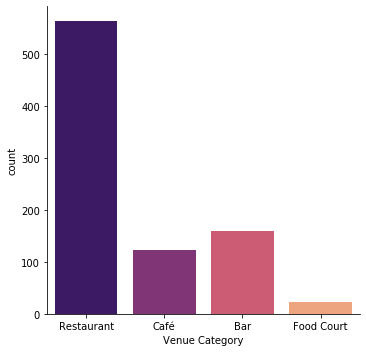

In [32]:
#Plot the Venues macro categoty 

import seaborn as sns
sns.catplot(x="Venue Category", kind="count", palette="magma", data=result)

### Analysis Dataframe

Then, I merged the Venue data and the charging station data using the Charging Point ID as key. In this way I obtained a database where each record represents a Venues which is close to a specific charged station. The last step was to obtain the dichotomic variable for the Venue category and to group the data by the charging point ID.

**The database contains the number of venues divided in four categories for each charging station. Moreover, it contains the number of total charging point and the total number of likes of off the venues around the selected charging station**.

Finally, I associated each Charging point to the related city suburbs by using a reverse geocoding process. In this way the final database includes also the city suburb where each station is located 


In [33]:
#Obtain the dummy variable 

result_onehot = pd.get_dummies(result[['Venue Category']], prefix="", prefix_sep="")
result_onehot.head()

Bar  Café  Food Court  Restaurant
0    0     0           0           1
1    0     0           0           1
2    0     0           0           1
3    0     0           0           1
4    0     0           0           1

In [34]:
DBdf=pd.concat([result, result_onehot], axis=1, sort=False)
DBdf = DBdf.drop(['Venue Category'] , axis='columns')
DBdf.head()

ChargePointID  Likes  NumbOfPoints  Longitude  Latitude  Bar  Café  \
0         149126  142.0           6.0   9.172799  45.45573    0     0   
1         149126   52.0           6.0   9.172799  45.45573    0     0   
2         149126   19.0           6.0   9.172799  45.45573    0     0   
3         149126   23.0           6.0   9.172799  45.45573    0     0   
4         149126   52.0           6.0   9.172799  45.45573    0     0   

   Food Court  Restaurant  
0           0           1  
1           0           1  
2           0           1  
3           0           1  
4           0           1

In [35]:
#Group by charging station

DBdf=DBdf.groupby(['ChargePointID','Longitude','Latitude']).sum()

DBdf = DBdf.reset_index(drop=False)
DBdf.head()

ChargePointID  Longitude   Latitude  Likes  NumbOfPoints  Bar  Café  \
0          21095   9.192996  45.489257   49.0           3.0    0     1   
1          21138   9.209498  45.447949   53.0           8.0    0     1   
2          21155   9.192835  45.459366  158.0          12.0    1     1   
3          21156   9.195366  45.463265  220.0           6.0    0     0   
4          21157   9.191669  45.467005  600.0          10.0    3     0   

   Food Court  Restaurant  
0           0           2  
1           1           2  
2           0           4  
3           0           3  
4           0           2

In [36]:
# Get the Suburb data or each ChargePointID (do it now to reduce number of API calls)

def getSuburb(latitudes, longitudes,name):
    
    Sub_list=[]
    for lat, lng, name in zip(latitudes, longitudes,name):
                
        url = 'https://api.opencagedata.com/geocode/v1/json?q={}%2C+{}&key=55258ae008f543058dd9a23dd008ccac&pretty=1'.format(
            lat, 
            lng)
            
        results55 = requests.get(url).json()["results"]
        
        try: 
        
         Sub_list.append([(
            name,
            v['components']['suburb']) for v in results55])
        
        except: 
        
          Sub_list.append([(
            name,
            v['components']['county']) for v in results55])
        

    MilanSuburb = pd.DataFrame([item for Sub_list in Sub_list for item in Sub_list])
    MilanSuburb.columns = ['ChargePointID',
                  'Suburb']
    
    return(MilanSuburb)   

In [37]:
Milan_Suburb1= getSuburb( DBdf['Latitude'], DBdf['Longitude'],DBdf['ChargePointID'])

In [38]:
Milan_Suburb1['Suburb'].unique()

array(['Isola', 'Porta Romana', 'Municipio 1', 'Municipio 3',
       'Città Studi', 'Milan', 'Porta Nuova', 'Porta Sempione', 'Musocco',
       'Portello', 'Porta Monforte', 'Porta Vittoria', 'Porta Genova',
       'Porta Vercellina', 'Tre Torri-Fiera', 'Bovisa', 'Municipio 9',
       'Municipio 6', 'Porta Lodovica', 'Bicocca', 'Baggio', 'Bruzzano',
       'Loreto', 'Porta Venezia', 'Municipio 2', 'Porta Garibaldi',
       'Molinazzo', 'Municipio 8', 'Sella Nuova', 'QT8', 'Municipio 5',
       'Bullona', 'Lambrate', 'Boldinasco', 'Chiesa Rossa', 'Lorenteggio',
       'San Cristoforo', 'Precotto', 'Moncucco', 'Municipio 4',
       'Municipio 7', 'Taliedo', 'Casoretto', 'Greco', 'Calvairate',
       'Niguarda', 'Crescenzago', 'Corvetto', 'Porta Ticinese',
       'Rogoredo'], dtype=object)

In [39]:
#Obtain the analysis dataframe 
DBdf['Suburb']=Milan_Suburb1['Suburb']

DBdf['Suburb'].unique()

array(['Isola', 'Porta Romana', 'Municipio 1', 'Municipio 3',
       'Città Studi', 'Milan', 'Porta Nuova', 'Porta Sempione', 'Musocco',
       'Portello', 'Porta Monforte', 'Porta Vittoria', 'Porta Genova',
       'Porta Vercellina', 'Tre Torri-Fiera', 'Bovisa', 'Municipio 9',
       'Municipio 6', 'Porta Lodovica', 'Bicocca', 'Baggio', 'Bruzzano',
       'Loreto', 'Porta Venezia', 'Municipio 2', 'Porta Garibaldi',
       'Molinazzo', 'Municipio 8', 'Sella Nuova', 'QT8', 'Municipio 5',
       'Bullona', 'Lambrate', 'Boldinasco', 'Chiesa Rossa', 'Lorenteggio',
       'San Cristoforo', 'Precotto', 'Moncucco', 'Municipio 4',
       'Municipio 7', 'Taliedo', 'Casoretto', 'Greco', 'Calvairate',
       'Niguarda', 'Crescenzago', 'Corvetto', 'Porta Ticinese',
       'Rogoredo'], dtype=object)

In [40]:
DBdfg=DBdf.groupby(['Suburb']).sum()
DBdfg = DBdfg.reset_index(drop=False)
DBdfg.head()

Suburb  ChargePointID  Longitude    Latitude  Likes  NumbOfPoints  Bar  \
0      Baggio          47994   9.096476   45.449970    0.0           2.0    0   
1     Bicocca          73182  18.423495   91.034368   12.0           6.0    1   
2  Boldinasco          93161   9.137276   45.498186    2.0           2.0    0   
3      Bovisa         416089  36.654897  182.007355   69.0          41.0    2   
4    Bruzzano          49060   9.192481   45.527612    0.0           6.0    0   

   Café  Food Court  Restaurant  
0     0           0           0  
1     0           0           1  
2     1           0           0  
3     4           0           8  
4     0           0           1

# Methodology and Analysis 

In order to pursue the analysis phase I decided to apply a K-means clustering model. I used the Final Database by grouping all the records by the Suburbs. **In this way each row was related to a single suburb and they contain the sum of number of charging point the sum of venues for each category and the sum of Likes of the venues associated to the single suburb**.

By applying a clusterization model on the suburbs’ information my aim was to divide the suburbs in some cluster characterized by the same features. **In this way it was possible to determine which suburbs cluster was the best in term of Charging Station network in relation to the closest venue and their reputation**. 

I chose to run the model for an incremental number of clusters starting from 2. **I used the average Silhouette score like index to choose the best number of clusters**.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. By computing the average for each object in a cluster it is possible to estimate a general index of fitness of the model. 



In [41]:
DBdfKN = DBdfg.drop(['Longitude','Latitude','ChargePointID','Suburb'] , axis='columns')
DBdfKN.head()

Likes  NumbOfPoints  Bar  Café  Food Court  Restaurant
0    0.0           2.0    0     0           0           0
1   12.0           6.0    1     0           0           1
2    2.0           2.0    0     1           0           0
3   69.0          41.0    2     4           0           8
4    0.0           6.0    0     0           0           1

In [43]:
from sklearn.preprocessing import StandardScaler
Clus_dataSet1 = DBdfKN
Clus_dataSet1 = np.nan_to_num(Clus_dataSet1)
Clus_dataSet1 = StandardScaler().fit_transform(Clus_dataSet1)

In [44]:
n=10
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
mean_acc = np.zeros((n-1))

for i in range(2,n):
    clusterNum = i
    k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 100)
    k_means.fit(Clus_dataSet1)
    labels = k_means.labels_
    k= silhouette_score(Clus_dataSet1, labels)
    mean_acc[i-1] = k
    print('The silhouette_score for',i,'clusters is',k)





The silhouette_score for 2 clusters is 0.850481021382247
The silhouette_score for 3 clusters is 0.5999900796423698
The silhouette_score for 4 clusters is 0.5514813689085527
The silhouette_score for 5 clusters is 0.46112297462140006
The silhouette_score for 6 clusters is 0.5031524834398747
The silhouette_score for 7 clusters is 0.5060960597819064
The silhouette_score for 8 clusters is 0.5084961977744283
The silhouette_score for 9 clusters is 0.4999661023621272


Like it is possible to see in the figure above the Silhouette score it is pretty good. I chose to use 3 clusters even if the score for two clusters is better. That’s why I would like to capture a more difference between the data. 

In [45]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 100)
k_means.fit(Clus_dataSet1)
labels = k_means.labels_
DBdfg['Clust']=labels

In [46]:
DBdfg.head(10)

Suburb  ChargePointID  Longitude    Latitude  Likes  NumbOfPoints  \
0        Baggio          47994   9.096476   45.449970    0.0           2.0   
1       Bicocca          73182  18.423495   91.034368   12.0           6.0   
2    Boldinasco          93161   9.137276   45.498186    2.0           2.0   
3        Bovisa         416089  36.654897  182.007355   69.0          41.0   
4      Bruzzano          49060   9.192481   45.527612    0.0           6.0   
5       Bullona          84020   9.164125   45.485541  248.0          16.0   
6    Calvairate         131204   9.220324   45.455478    0.0           6.0   
7     Casoretto         129306   9.228053   45.484745  353.0           8.0   
8  Chiesa Rossa          93305   9.172916   45.440627   38.0           6.0   
9   Città Studi         249471  36.908430  181.916953  439.0          26.0   

   Bar  Café  Food Court  Restaurant  Clust  
0    0     0           0           0      0  
1    1     0           0           1      0  
2    0     1           0           0      0  
3    2     4           0           8      0  
4    0     0           0           1      0  
5    2     2           0          12      0  
6    0     0           0           1      0  
7    1     1           0           2      0  
8    1     0           1           1      0  
9    0     0           2           8      0

In [69]:
DBdfg['Clust'].unique()

array([0, 1, 2])

# Results

By running the model with 3 cluster I obtained the distribution on the figure below 

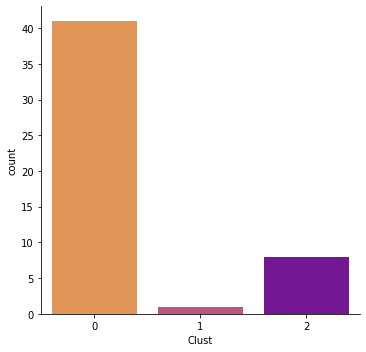

In [66]:
sns.catplot(x="Clust", kind="count", palette="plasma_r", data=DBdfg)

In [72]:
Cluster0=DBdfg[DBdfg['Clust']==0]
Cluster1=DBdfg[DBdfg['Clust']==1]
Cluster2=DBdfg[DBdfg['Clust']==2]
Cluster2

Suburb  ChargePointID  Longitude    Latitude   Likes  \
25      Municipio 6         365260  36.636513  181.806725  1961.0   
28      Municipio 9         193582  36.785400  181.939688  1489.0   
31  Porta Garibaldi         382852  36.750176  181.923286  2452.0   
32     Porta Genova         253180  36.691915  181.823330  2118.0   
35      Porta Nuova         343420  45.999637  227.390959  3812.0   
36     Porta Romana         494912  46.031178  227.253330  3227.0   
37   Porta Sempione         201784  27.508392  136.435765   917.0   
42         Portello         493758  54.898630  272.925772  1054.0   

    NumbOfPoints  Bar  Café  Food Court  Restaurant  Clust  
25          53.0    3     4           1          23      2  
28         126.0    5     2           2          28      2  
31          87.0   10     4           1          26      2  
32         157.0    6     4           1          40      2  
35          96.0   22     3           1          33      2  
36         310.0   21     6           2          52      2  
37          53.0    7     3           1          24      2  
42         130.0    1     7           3          27      2

In [73]:
Result77={'Drivers':['Likes','NumbOfPoints','Bar','Food Court','Restaurant','Cafè'],'Cluster0':[Cluster0['Likes'].mean(),Cluster0['NumbOfPoints'].mean(),Cluster0['Bar'].mean(),Cluster0['Food Court'].mean(),Cluster0['Restaurant'].mean(),Cluster0['Café'].mean()],'Cluster1':[Cluster1['Likes'].mean(),Cluster1['NumbOfPoints'].mean(),Cluster1['Bar'].mean(),Cluster1['Food Court'].mean(),Cluster1['Restaurant'].mean(),Cluster1['Café'].mean()],'Cluster2':[Cluster2['Likes'].mean(),Cluster2['NumbOfPoints'].mean(),Cluster2['Bar'].mean(),Cluster2['Food Court'].mean(),Cluster2['Restaurant'].mean(),Cluster2['Café'].mean()]}
Result77 = pd.DataFrame(Result77)
Result77=Result77.set_index('Drivers')
Result77=Result77.round(1)
Result77

Cluster0  Cluster1  Cluster2
Drivers                                   
Likes            207.3   11598.0    2128.8
NumbOfPoints      20.1     398.0     126.5
Bar                1.0      43.0       9.4
Food Court         0.2       4.0       1.5
Restaurant         4.8     114.0      31.6
Cafè               1.3      35.0       4.1

It is clear that the best cluster is the number 1 with many charging points and with many venues with high rate. Moreover, there are more Bar and Café respect to the other cluster. The second best is the cluster 2 with a good number of venues and charging points. 

At the opposite, the cluster 0 includes suburbs with a smaller number of charging points and most important with not many venues around them (also with less reputation!). This mean that this cluster repress the suburbs where the charging network is not well developed and ready to support a dynamic charging trend of the EV owner. 


In [55]:
Milan_map4 = folium.Map(location=[45.4654219, 9.1859243],width='80%', height='60%',control_scale=True, zoom_start=11)
url = r'http://dati.comune.milano.it/dataset/e8e765fc-d882-40b8-95d8-16ff3d39eb7c/resource/9c4e0776-56fc-4f3d-8a90-f4992a3be426/download/ds964_nil_wm.geojson'
folium.GeoJson(url).add_to(Milan_map4)

In [56]:
df1 = DBdfg[['Suburb','Clust']]
DBdfGEO=DBdf.merge(df1,on='Suburb')
DBdfGEO.head()

ChargePointID  Longitude   Latitude   Likes  NumbOfPoints  Bar  Café  \
0          21095   9.192996  45.489257    49.0           3.0    0     1   
1          21138   9.209498  45.447949    53.0           8.0    0     1   
2          73127   9.203579  45.451494  1077.0          80.0    8     2   
3         130458   9.205586  45.454665   864.0          60.0    6     0   
4         135094   9.203707  45.451353  1049.0         120.0    7     2   

   Food Court  Restaurant        Suburb  Clust  
0           0           2         Isola      0  
1           1           2  Porta Romana      2  
2           0          10  Porta Romana      2  
3           0          24  Porta Romana      2  
4           0          11  Porta Romana      2

In [57]:
Cluster0g=DBdfGEO[DBdfGEO['Clust']==0]
Cluster1g=DBdfGEO[DBdfGEO['Clust']==1]
Cluster2g=DBdfGEO[DBdfGEO['Clust']==2]

### Cluster 0

The cluster 0 (in blue) even if includes most of the suburbs like we have seen before it has few charging stations. It means that the peripheric suburbs do not have many venues around the charging station and they have less charging points in comparison with the suburbs in the other clusters

In [58]:
for lat, lng, label in zip(Cluster0g['Latitude'], Cluster0g['Longitude'], Cluster0g['Suburb']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(Milan_map4)  
    
Milan_map4

### Cluster 1

If we take a look to the singles charging station, we can see how the ones in the cluster 1 (in yellow) are in the Historic Centre suburb. 

In [59]:
for lat, lng, label in zip(Cluster1g['Latitude'], Cluster1g['Longitude'], Cluster1g['Clust']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(Milan_map4)  
    
Milan_map4

### Cluster 2

While, the station in the cluster 2 (in red) are in the suburbs around the center and on the main road converging to the heart of the city. These suburbs are Porta Garibaldi, Porta Genova, Porta Nuova, Porta Romana, Porta Sempione, Pioltello, Municipio 6 and Municipio 7.

In [60]:
for lat, lng, label in zip(Cluster2g['Latitude'], Cluster2g['Longitude'], Cluster2g['Clust']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(Milan_map4)  
    
Milan_map4

# Conclusion

In conclusion the clusterization model show an interesting trend. The fact that the suburbs near the center are the only one ready in terms of charging stations and available venues around them while the suburbs in the peripheric zone are dramatically less equipped is the prove of the lack of a infrastructural plan.

Indeed, the charging points are located mostly in the city center suburbs because of the popularity of the EV vehicles in these zones and because of the large amount of people using these vehicles within these areas. Moreover, the availability of interesting Venues like Bar and Café is an effect of the proximity o the touristic and most popular area of the city. For this reason, the charging station in this area could take advantage of this infrastructures. 

On the other sides far from the city center the charging infrastructure is far less developed. There are not many charging points, and these are located in isolated zone without any facilities around them. So, it is clear that there is not any plan to promote a uniform development of the infrastructure by the municipality. Furthermore, the lack of Venues around the charging point in the suburbs could limit their use because the drivers travelling through Milan to another city may avoid charging their car because the lack of place to wait during  the charging process. This could reduce the EV penetration in the market because by limiting the range of use of these vehicles. The idea of buying an EV without having the real change of charging them during the day unless going in the center of the city, make the EV choice far less attractive. 

**The model shows clearly the limit of a charging infrastructure development plan which do not follow the potential clients needs but it only aims to make easy and sure profit where their EV are already popular**.

**The municipality should encourage the development of the charging network also outside the city center. This will start a virtuous cycle by spreading the use of the EV and convincing the investor to build new venues around the charging stations**.  
 
